# Response matrices

In [1]:
import at
import numpy as np
import math
from pathlib import Path
from importlib.resources import files, as_file
from timeit import timeit
from at.future import VariableList, RefptsVariable

In [2]:
with as_file(files("machine_data") / "hmba.mat") as path:
    hmba_lattice = at.load_lattice(path)

In [3]:
for sx in hmba_lattice.select(at.Sextupole):
    sx.KickAngle=[0,0]
hmba_lattice.enable_6d()

In [4]:
ring = hmba_lattice.repeat(8)

A {py:class}`.ResponseMatrix` object defines a general-purpose response matrix, based
on a {py:class}`.VariableList` of attributes which will be independently varied, and an
{py:class}`.ObservableList` of attributes which will be recorded for each
variable step.

{py:class}`.ResponseMatrix` objects can be combined with the "+" operator to define
combined responses. This concatenates the variables and the observables.

The module also defines two commonly used response matrices:
{py:class}`.OrbitResponseMatrix` for circular machines and
{py:class}`.TrajectoryResponseMatrix` for beam lines. Other matrices can be easily
defined by providing the desired Observables and Variables to the
{py:class}`.ResponseMatrix` base class.

## General purpose response matrix

Let's take the horizontal displacements of all quadrupoles as variables:

In [5]:
variables = VariableList(RefptsVariable(ik, "dx", name=f"dx_{ik}", delta=.0001)
                        for ik in ring.get_uint32_index(at.Quadrupole))

Variable names are set to _dx\_nnnn_ where _nnnn_ is the index of the quadrupole in the ring.

Let's take the horizontal positions at all beam position monitors as observables:

In [6]:
observables = at.ObservableList([at.OrbitObservable(at.Monitor, axis='x')])

We have a single Observable named _orbit[x]_ by default, with multiple values.

### Instantiation

In [7]:
resp_dx = at.ResponseMatrix(variables, observables, ring=ring)

At that point, the response matrix is empty.

### Matrix Building

A general purpose response matrix may be filled by several methods:

1. Direct assignment of an array to the {py:attr}`~.ResponseMatrix.response` property.
   The shape of the array is checked,
2. {py:meth}`~.ResponseMatrix.load` loads data from a file containing previously
   saved values or experimentally measured values,
3. {py:meth}`~.ResponseMatrix.build` computes the matrix using tracking,
4. For some specialized response matrices
   {py:meth}`~.OrbitResponseMatrix.build_analytical` is available.


In [8]:
resp_dx.build(use_mp=True)

Saving variables
Restoring variables


array([[ 16.94897864,  -7.67022307,   2.50968594, ...,   5.3125638 ,
         -5.57239476,  14.39501938],
       [-10.6549627 ,   3.59085167,  -6.21666755, ...,  -2.46632948,
          8.42841189, -18.50171186],
       [-10.99744814,   3.91741643,  -5.60080281, ...,  -2.73604877,
          7.61448343, -17.01886021],
       ...,
       [-17.0182359 ,   7.61358522,  -2.73824047, ...,  -5.60018031,
          3.92050176, -11.00305834],
       [-18.50166601,   8.42772786,  -2.46888914, ...,  -6.21619686,
          3.59444354, -10.66160249],
       [ 14.38971545,  -5.56943704,   5.31320321, ...,   2.50757509,
         -7.6711941 ,  16.94982252]], shape=(80, 128))

### Matrix normalisation

To be correctly inverted, the response matrix must be correctly normalised: the norms
of its columns must be of the same order of magnitude, and similarly for the rows.

Normalisation is done by adjusting the weights {math}`w_v` for the variables {math}`\mathbf{V}`
and {math}`w_o` for the observables {math}`\mathbf{O}`.
With {math}`\mathbf{R}` the response matrix:

:::{math}

   \mathbf{O} = \mathbf{R} . \mathbf{V}
:::

The weighted response matrix {math}`\mathbf{R}_w` is:

:::{math}

   \frac{\mathbf{O}}{w_o} = \mathbf{R}_w . \frac{\mathbf{V}}{w_v}
:::
The {math}`\mathbf{R}_w` is dimensionless and should be normalised. This can be checked
using:

* {py:meth}`~.ResponseMatrix.check_norm` which prints the ratio of the maximum / minimum
  norms for variables and observables. These should be less than 10.
* {py:meth}`~.ResponseMatrix.plot_norm`

Both natural and weighted response matrices can be retrieved with the
{py:meth}`~.ResponseMatrix.response` and {py:meth}`~.ResponseMatrix.weighted_response`
properties.

max/min Observables: 2.8352796928877217
max/min Variables: 4.768846272300096


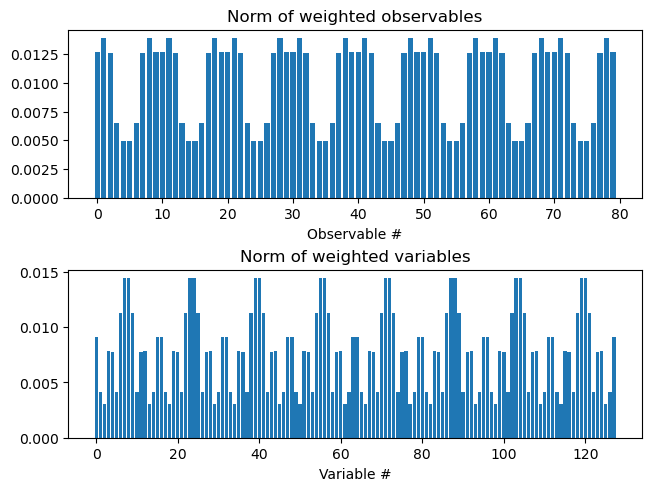

In [9]:
resp_dx.plot_norm()

### Matrix pseudo-inversion

The {py:meth}`~.ResponseMatrix.solve` method computes the singular values of the
weighted response matrix and its pseudo-inverse.

In [10]:
resp_dx.solve()

We can plot the singular values:

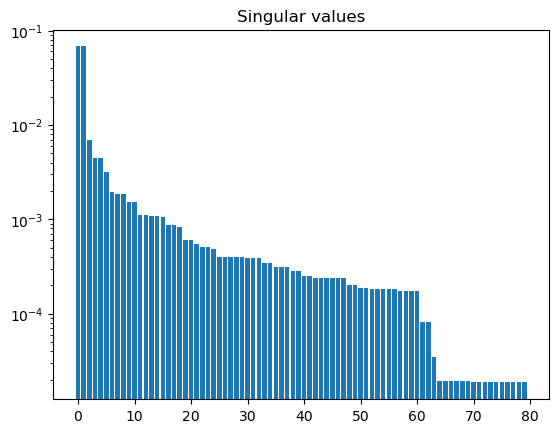

In [11]:
resp_dx.plot_singular_values()

After solving, correction is available, for instance with

* {py:meth}`~.ResponseMatrix.correction_matrix` which returns the correction matrix (pseudo-inverse of
  the response matrix),
* {py:meth}`~.ResponseMatrix.get_correction` which returns a correction vector when given observed values,
* {py:meth}`~.ResponseMatrix.correct` which computes and optionally applies a correction
  for the provided {py:class}`.Lattice`.

### Exclusion of variables and observables

Variables may be added to a set of excluded values, and similarly for observables.
Excluding an item does not change the response matrix. The values are excluded from the
pseudo-inversion of the response, possibly reducing the number of singular values.
After inversion, the correction matrix is expanded to its original size by inserting
zero lines and columns at the location of excluded items. This way:

- error and correction vectors keep the same size independently of excluded values,
- excluded error values are ignored,
- excluded corrections are set to zero.

#### Exclusion of variables

Excluded variables are selected by their name or their index in the variable list:

In [12]:
resp_dx.exclude_vars(0, "dx_9", "dx_47", -1)

Where *-1* refers to the last variable.

#### Exclusion of observables

Observables are selected by their name or their index in the observable list. In addition, for
{py:class}`.ElementObservable` observables, we need to specify a _refpts_ to identify which item
in the array will be excluded.

Let's exclude all Monitors with name _BPM\_07_:

In [13]:
resp_dx.exclude_obs(obsid="orbit[x]", refpts="BPM_07")

Or by using the observable index:

In [14]:
resp_dx.exclude_obs(obsid=0, refpts="BPM_07")

/var/folders/w4/c1rp88qs29742fy2f201n9400000gn/T/ipykernel_90643/1399543609.py:1: AtWarning: No new excluded value
  resp_dx.exclude_obs(obsid=0, refpts="BPM_07")


Or even, since there is a single observable and *obsid* defaults to *0*:

In [15]:
resp_dx.exclude_obs(refpts="BPM_07")

/var/folders/w4/c1rp88qs29742fy2f201n9400000gn/T/ipykernel_90643/3319419291.py:1: AtWarning: No new excluded value
  resp_dx.exclude_obs(refpts="BPM_07")


After excluding items, the pseudo-inverse is discarded so one must recompute it again:

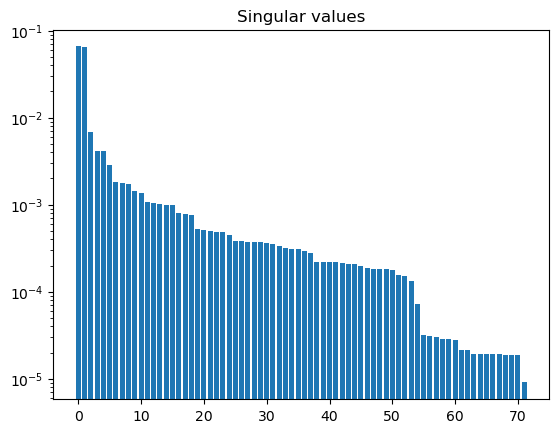

In [16]:
resp_dx.solve()
resp_dx.plot_singular_values()

There are now only 72 singular values instead of 80 (number of active monitors).

The excluded items can be retrieved with the {py:attr}`~.ResponseMatrix.excluded_obs` and
{py:attr}`~.ResponseMatrix.excluded_vars` properties:

In [17]:
print(resp_dx.excluded_obs)
print(resp_dx.excluded_vars)

{'orbit[x]': array([ 79, 200, 321, 442, 563, 684, 805, 926], dtype=uint32)}
['dx_5', 'dx_9', 'dx_47', 'dx_964']


The exclusion masks can be reset using {py:meth}`~.ResponseMatrix.reset_vars` and
{py:meth}`~.ResponseMatrix.reset_obs`.

## Orbit response matrix

An {py:class}`.OrbitResponseMatrix` defines its observables as instances of
{py:class}`.OrbitObservable` and its variables as _KickAngle_ attributes of elements.

### Instantiation

By default, the observables are all the {py:class}`.Monitor` elements, and the
variables are all the elements having a *KickAngle* attribute. This is equivalent to:
```python
resp_v = at.OrbitResponseMatrix(ring, "v", bpmrefs = at.Monitor,
                                steerrefs = at.checkattr("KickAngle"))
```
The variable elements must have the *KickAngle* attribute used for correction.
It's available for all magnets, though not present by default except in
{py:class}`.Corrector` magnets. For other magnets, the attribute should be
explicitly created.

There are options in {py:class}`.OrbitResponseMatrix` to include the RF frequency in the
variable list, and the sum of correction angles in the list of observables:

In [18]:
resp_h = at.OrbitResponseMatrix(ring, "h", cavrefs=at.RFCavity, steersum=True)
print(resp_h.shape)

(81, 49)


### Matrix building

{py:class}`.OrbitResponseMatrix` has a {py:meth}`~.OrbitResponseMatrix.build_analytical` build method,
using formulas from [^Franchi].

[^Franchi]: A. Franchi, S.M. Liuzzo, Z. Marti, _"Analytic formulas for the rapid evaluation of the orbit
response matrix and chromatic functions from lattice parameters in circular accelerators"_,
arXiv:1711.06589 [physics.acc-ph]

In [19]:
resp_h.build_analytical()

array([[-8.54870374e+00, -1.81104969e+01, -1.21497454e+01, ...,
        -2.85830326e+01, -1.60772960e+01, -5.75838151e-08],
       [ 1.85290756e+01,  3.16574224e+01,  1.82799745e+01, ...,
         1.90656557e+01,  8.85865108e+00, -2.68128309e-06],
       [ 1.68213604e+01,  2.87634523e+01,  1.65301788e+01, ...,
         1.94726063e+01,  9.44097149e+00, -2.44436213e-06],
       ...,
       [ 8.84897619e+00,  1.90656922e+01,  1.29411619e+01, ...,
         3.16578009e+01,  1.85390265e+01, -2.68138514e-06],
       [-1.60775574e+01, -2.85833742e+01, -1.65903209e+01, ...,
        -1.81113028e+01, -8.54900471e+00, -5.76356368e-08],
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
         1.00000000e+00,  1.00000000e+00,  0.00000000e+00]],
      shape=(81, 49))

### Matrix normalisation

This is critical when including the RF frequency response which is not commensurate
with steerer responses. Similarly for rows, the sum of steerers is not commensurate with
monitor readings.

By default, the normalisation is done automatically by adjusting the RF frequency step
and the weight of the steerer sum based on an approximate analytical response matrix.
Explicitly specifying the *cavdelta* and *stsumweight* prevents this automatic normalisation.

After building the response matrix, and before solving, normalisation may be applied
with the {py:meth}`~.OrbitResponseMatrix.normalise` method. The default normalisation
gives a higher priority to RF response and steerer sum.

## Trajectory response matrix

A {py:class}`.TrajectoryResponseMatrix` defines its observables as instances of
{py:class}`.TrajectoryObservable` and its variables as _KickAngle_ attributes of elements.

### Instantiation

By default, the observables are all the {py:class}`.Monitor` elements, and the
variables are all the elements having a *KickAngle* attribute. This is equivalent to:
```python
resp_v = at.TrajectoryResponseMatrix(lattice, "v", bpmrefs = at.Monitor,
                                     steerrefs = at.checkattr("KickAngle"))
```
The variable elements must have the *KickAngle* attribute used for correction.
It's available for all magnets, though not present by default except in
{py:class}`.Corrector` magnets. For other magnets, the attribute should be
explicitly created.

In [20]:
resp_h = at.TrajectoryResponseMatrix(ring, "h")
print(resp_h.shape)

(80, 48)


## References